This notebook develops an efficient method for integrating the Lorenz 1963 equation.  The initial implementation uses the Runge-Kutta 3rd order time integration of Shu (2003, Int J. Comp. Fl. Dyn.).

In [1]:
import numpy as np
import matplotlib.pyplot as PP
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# A simple (slow) implementation of the Lorenz (1963) model

In [2]:
from __future__ import division # so that division of an integer can produce a float in python 2.7
import numpy as np

# pre-declare a tendency array so that it doesn't have to
# be re-declared each time within the timestep loop (which would be slow)
__xyzTend = np.zeros([3],dtype=float)

def lorenz63Tendencies(xyz, \
                       sigma=10, \
                       r=28, \
                       b=8/3, \
                       deltaT = 0.01):
    """Returns the time tendencies of system variables X, Y, and Z following Lorenz (1963, J. Atmos. Sci.)
    
        input:
        ------
            xyz      : a numpy array of length 3 containing the current values of X, Y, and Z
            sigma    : The system's Prandtl number
            r        : The system's relative Rayleigh number (actual over critical)
            b        : The Saltzman (1962) parameter controling the system's critical Rayleigh number
            deltaT   : The dimensionless timestep
        
        output:
        -------
            A numpy array of length 3 containing the time tendencies of X, Y, and Z
        
        According to Lorenz (1963):
        
        > In these equations X is proportional to the intensity of the 
        > convective motion, while Y is proportional to the temperature
        > difference between the ascending and descending currents,
        > similar signs of X and Y denoting that warm fluid is rising and 
        > cold fluid is descending. The variable Z is proportional to the 
        > distortion of the vertical temperature profile from linearity,
        > a positive value indicating that the strongest gradients occur
        > near the boundaries.
    """
    
    #Extract x,y,z from the xyz vector for readability
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    
    #Calculate the time tendencies of X, Y, and Z
    #( from Lorenz 1963 eqns 25, 26, and 27)
    dxdt = sigma*(y-x)
    dydt = -x*z + r*x - y
    dzdt = x*y - b*z
    
    #Convert the time derivatives into tendencies
    __xyzTend[0] = dxdt * deltaT
    __xyzTend[1] = dydt * deltaT
    __xyzTend[2] = dzdt * deltaT
    
    return __xyzTend
    
def integrateL63(  xyz, \
                   nstep = 1, \
                   sigma = 10 * np.ones([1],dtype=float), \
                   r = 28*np.ones([1],dtype=float), \
                   b = 8/3*np.ones([1],dtype=float), \
                   deltaT = 0.01):
    """Integrates the Lorenz (1963, J. Atmos. Sci.) system of X, Y, and Z variables 
       using the RK3 method of Shu (2003, Int. J. Comp. Fl. Dyn)
    
        input:
        ------
            xyz       : a numpy array of length 3 containing the current values of X, Y, and Z
            nstep     : The number of time steps for which to integrate
            sigma     : The system's Prandtl number
            r         : The system's relative Rayleigh number (actual over critical)
            b         : The Saltzman (1962) parameter controling the system's critical Rayleigh number
            deltaT    : The dimensionless timestep
        
        output:
        -------
            A numpy array of shape [3,nstep+1] containing the integrated values of X, Y, and Z
            (timestep 0 holds the initial value)
        
        According to Lorenz (1963):
        
        > In these equations X is proportional to the intensity of the 
        > convective motion, while Y is proportional to the temperature
        > difference between the ascending and descending currents,
        > similar signs of X and Y denoting that warm fluid is rising and 
        > cold fluid is descending. The variable Z is proportional to the 
        > distortion of the vertical temperature profile from linearity,
        > a positive value indicating that the strongest gradients occur
        > near the boundaries.
    """
    
    #Check that the sizes of the input parameter arrays conform to nstep
    if len(sigma) != nstep:
        sigma = sigma[0]*np.ones([nstep],dtype=float)
    if len(r) != nstep:
        r = r[0]*np.ones([nstep],dtype=float)
    if len(b) != nstep:
        b = b[0]*np.ones([nstep],dtype=float)
    
    # pre-declare some simple arrays for convenience
    # in doing the runge-kutta integration
    dxyz = np.zeros([3],dtype=float)
    xyz1 = np.zeros([3],dtype=float)
    xyz2 = np.zeros([3],dtype=float)
    xyz_np1 = np.zeros([3],dtype=float)
    
    #Pre-declare the xyzOut array
    xyzOut = np.zeros([3,nstep+1],dtype=np.float)
    
    #Set timestep 0 to the initial condition
    for i in range(3):
        xyzOut[i,0] = xyz[i]
    
    for n in range(1,nstep+1):
        
        #*************************************
        # Perform the runge-kutta integration
        #*************************************
        
        #Stage 1
        dxyz = lorenz63Tendencies(xyz,sigma[n-1],r[n-1],b[n-1],deltaT)
        for i in range(3):
            xyz1[i] = xyz[i] + dxyz[i]

        #Stage 2
        dxyz = lorenz63Tendencies(xyz1,sigma[n-1],r[n-1],b[n-1],deltaT)
        for i in range(3):
            xyz2[i] = 3/4*xyz[i] + 1/4*xyz1[i] + 1/4*dxyz[i]

        #Stage 3 (final stage)
        dxyz = lorenz63Tendencies(xyz2,sigma[n-1],r[n-1],b[n-1],deltaT/2)
        for i in range(3):
            #Do the final stage
            xyz_np1[i] = 1/3*xyz[i] + 2/3*xyz2[i] + 4/3*dxyz[i]
            
            #Save the updated value in the output array
            xyzOut[i,n] = xyz_np1[i]
            
            #Set the current xyz to the new value for the next loop iteration
            xyz[i] = xyz_np1[i]
    
    return xyzOut
    

# Verifying the model
The Lorenz (1963) [L63] model is implemented in Python as follows. The tendencies (given by Equations 25, 26, and 17 in L63) are directly calculated in the `lorenz63Tendencies()` subroutine.  The `integrateL63()` method, which serves as the main interface to the solver, uses the 3$^{rd}$-order Runge-Kutta time integration method described by Shu (2003, Int. J. Comp. Fl. Dyn.) to step the model forward in time.

The control parameters of the model, $\sigma$, $r$, and $b$ are given default values that match the values used in L63.  However, the code is written in such a way that the control paramters can be provided as arrays that vary with time (which requires that the length of such an array be equal to the `nstep` parameter).  This allows experiments in which these control paramters vary in time.

To start, let's check the default output of this model:

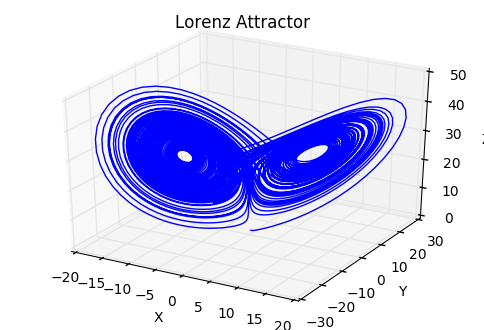

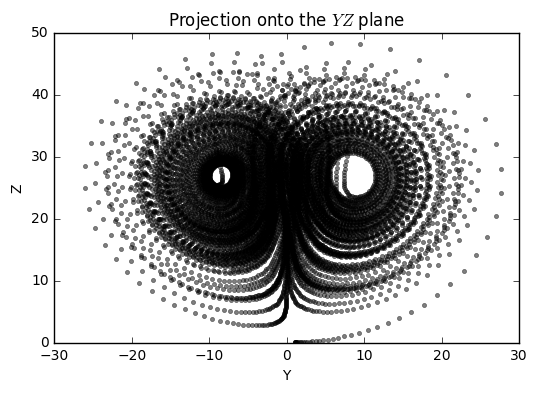

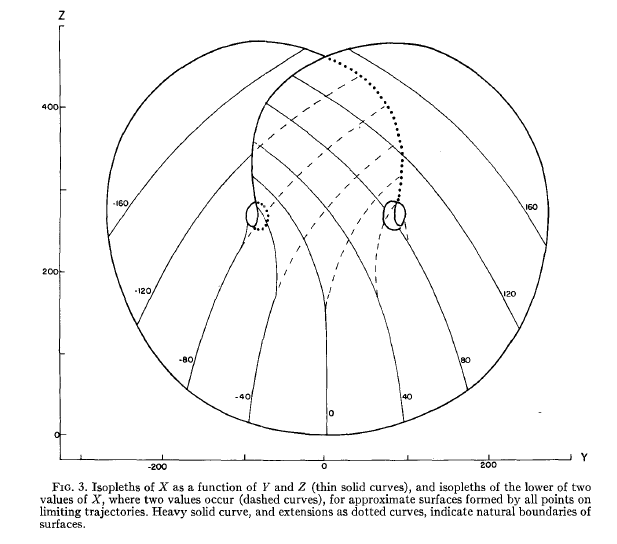

In [3]:
#***********************************
# Run the default Lorenz 1963 model
#***********************************

#Start the Lorenz model with the same state that Lorenz uses in his 1963 paper
xyz = np.array([0,1,0],dtype=np.float)
#Run the Lorenz model for 10000 steps using the parameters from his paper
xyzOut = integrateL63(xyz,nstep=10000)

#***************************
# Plot the phase space plot
#***************************
#Initialize the plot
fig = PP.figure()
ax = fig.gca(projection='3d')

#Extract the state variables from the model's output array
xs = xyzOut[0,:]
ys = xyzOut[1,:]
zs = xyzOut[2,:]

#Plot the attractor
ax.plot(xs, ys, zs)
#Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")

PP.show()

PP.plot(ys,zs,'k.',alpha=0.5)
PP.xlabel('Y')
PP.ylabel('Z')
PP.title('Projection onto the $YZ$ plane')
PP.show()

from IPython.display import Image
Image(filename='Lorenz1963_Fig3.png')
 

Qualitatively, this looks like the expected 'butterfly' shaped plot with two attractors around which the system orbits.

Quantitatively, comparing the projection of the simulation onto the $YZ$ plane with Figure 3 of Lorenz (1963), we see that the $Y$ values are limited to $\pm$ 30 and the $Z$ values are limited to $\pm 50$.  This is consistent with L63 Figure 3, where the respective limits are $\pm 300$ and $\pm 500$ (in the text, Lorenz describes Table 1 as listing values scaled by 10 (and the values in Table 1 are typically in the 100s), so presumably Figure 3 must also be scaled by a factor of 10.

Given this, I am confident that the model is written correctly and that it is exhibiting the same behavior as the model implementation in Lorenz (1963).

#Time-varying forcing
Now let's investigate the behavior of the model with time-varying forcing.

For this experiment, I'll vary the relative Rayleigh number $r$, such that it is constant and below the critical value of 24.74 for the first half of the timeseries and linearly increasing to a super-critical value for the second half.

/Users/taobrien/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


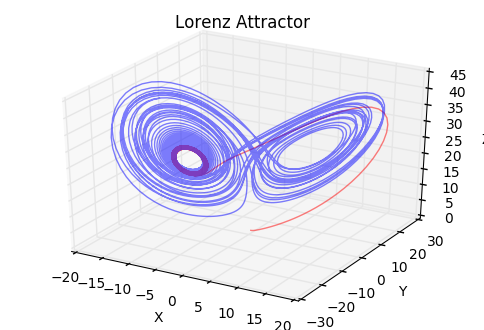

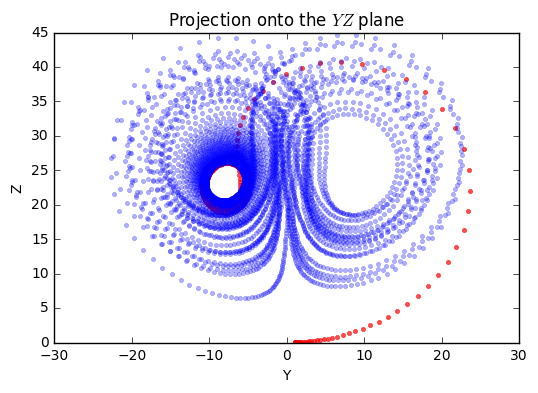

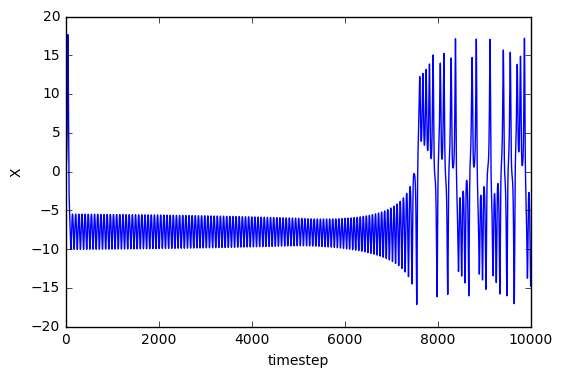

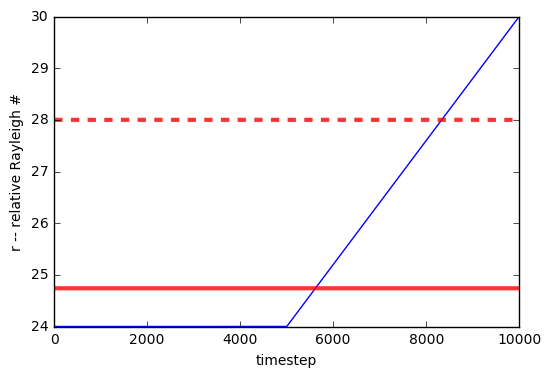

In [4]:
#***********************************
# Run the L63 with time-varying r
#***********************************
#Start the Lorenz model with the same state that Lorenz uses in the 1963 paper
xyz = np.array([0,1,0],dtype=np.float)

#Set the number of timesteps
nstep = 10000
#Set the start and end values of r
rstart = 24
rend = 30
#Give the first half a constant, sub-critical r value
r = rstart*np.ones([nstep/2])
#Concatenate this with a 2nd half that linearly increases to a super-critical r value
r = np.concatenate( (r, np.linspace(rstart,rend,nstep/2)))
#Run the model with this time-varying forcing
xyzOut = integrateL63(xyz,nstep=len(r),r=r)

#********************
# Plot model's state
#********************
#initialize the figure
fig = PP.figure()
ax = fig.gca(projection='3d')

#extract the state variables from the output
xs = xyzOut[0,:]
ys = xyzOut[1,:]
zs = xyzOut[2,:]

#Plot the first half of the timeseries as red
s = slice(None,int(len(r)/2))
ax.plot(xs[s], ys[s], zs[s],color='r',alpha=0.5)
#Plot the 2nd half as blue
s = slice(int(len(r)/2),None)
ax.plot(xs[s], ys[s], zs[s],color='b',alpha=0.5)

#set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")

PP.show()

#Plot the projection onto the YZ plane
s = slice(None,int(len(r)/2))
PP.plot(ys[s],zs[s],'r.',alpha=0.7)
s = slice(int(len(r)/2),None)
PP.plot(ys[s],zs[s],'b.',alpha=0.3)
PP.xlabel('Y')
PP.ylabel('Z')
PP.title('Projection onto the $YZ$ plane')
PP.show()

#***************************
# Plot timeseris of X and r
#***************************
PP.plot(xs)
PP.xlabel('timestep')
PP.ylabel('X')
PP.show()
PP.plot(r)
rcrit = 24.74 #Relative critical Rayleigh # above which convection starts (from Lorenz 1963)
PP.plot(np.arange(len(r)),rcrit*np.ones(len(r)),color='r',alpha=0.8,linewidth=3)
PP.plot(np.arange(len(r)),28*np.ones(len(r)),color='r',linestyle='--',alpha=0.8,linewidth=3)
PP.ylabel('r -- relative Rayleigh #')
PP.xlabel('timestep')
PP.show()

In the above 'Lorenz Attractor' plot, the first half of the simulation is plotted as the red line, and the second half is plotted as blue.  It is clear that with a sub-critical value of $r$, the system sits in a periodic state that appears to orbit the null region of the leftmost attractor. Once $r$ starts increasing at $t=5000$, the amplitude of the oscillations starts to decrease until the system crosses $r_c = 24.74$ (the solid red line).  The amplitude of the oscillations increases after this point until time $t \approx 7500$, which corresponds to $r$ just below the value of 28 used by L63.  After this point the system transitions into the non-periodic, chaotic state of orbiting both attractors.

# Noise in the forcing
Now let's repeat the above experiment, but with noise in the forcing term.  

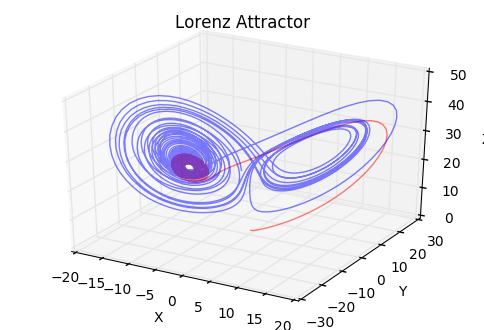

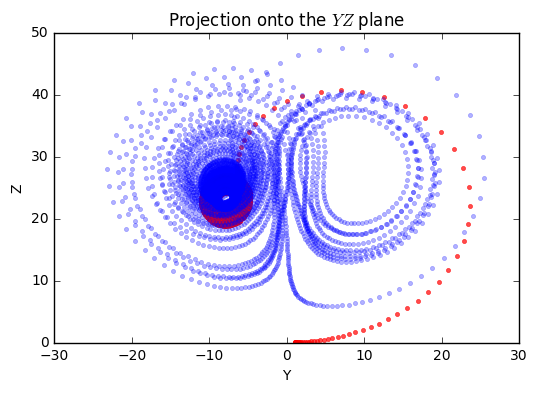

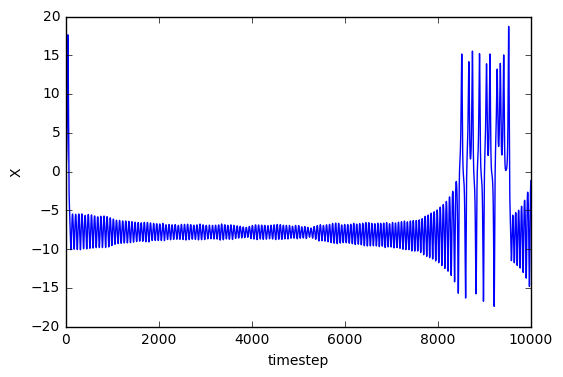

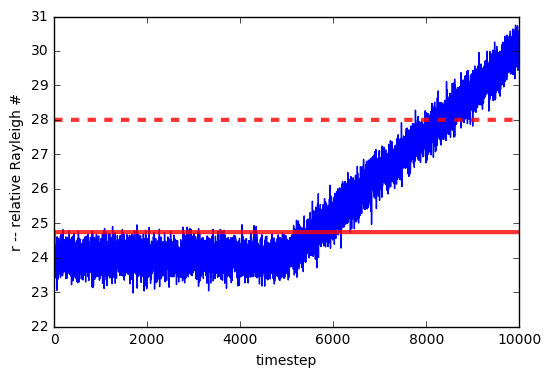

In [5]:
#Again start the Lorenz model with the same state that Lorenz uses in the 1963 paper
xyz = np.array([0,1,0],dtype=np.float)

#Set the number of timesteps
nstep = 10000
#Set the start and end values of r
rstart = 24
rend = 30
#Set the scale of the noise
noiseScale = 0.3
#Set the 1st half with quasi-constant (but noisy) sub-critical r
r = rstart*np.ones([int(nstep/2)]) + np.random.normal(scale=noiseScale,size=int(nstep/2))
#Concatenate that half with the second half that linearly increases to a super-critical value
#(again with the same level of noise)
r = np.concatenate((r, \
                    np.linspace(rstart,rend,int(nstep/2)) + np.random.normal(scale=noiseScale,size=int(nstep/2)), \
                ))
#Run the model
xyzOut = integrateL63(xyz,nstep=len(r),r=r)

#********************
# Plot model's state
#********************
#initialize the figure
fig = PP.figure()
ax = fig.gca(projection='3d')

#extract the state variables from the output
xs = xyzOut[0,:]
ys = xyzOut[1,:]
zs = xyzOut[2,:]

#Plot the first half of the timeseries as red
s = slice(None,int(len(r)/2))
ax.plot(xs[s], ys[s], zs[s],color='r',alpha=0.5)
#Plot the 2nd half as blue
s = slice(int(len(r)/2),None)
ax.plot(xs[s], ys[s], zs[s],color='b',alpha=0.5)

#set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")

PP.show()

#Plot the projection onto the YZ plane
s = slice(None,int(len(r)/2))
PP.plot(ys[s],zs[s],'r.',alpha=0.7)
s = slice(int(len(r)/2),None)
PP.plot(ys[s],zs[s],'b.',alpha=0.3)
PP.xlabel('Y')
PP.ylabel('Z')
PP.title('Projection onto the $YZ$ plane')
PP.show()

#***************************
# Plot timeseris of X and r
#***************************
PP.plot(xs)
PP.xlabel('timestep')
PP.ylabel('X')
PP.show()
PP.plot(r)
rcrit = 24.74 #Relative critical Rayleigh # above which convection starts (from Lorenz 1963)
PP.plot(np.arange(len(r)),rcrit*np.ones(len(r)),color='r',alpha=0.8,linewidth=3)
PP.plot(np.arange(len(r)),28*np.ones(len(r)),color='r',linestyle='--',alpha=0.8,linewidth=3)
PP.ylabel('r -- relative Rayleigh #')
PP.xlabel('timestep')
PP.show()



In the above experiment, I have repeated it a number of times, and the transition time jumps around; sometimes it occurs early in the timeseries, and sometimes it occurs late.  However, the orbits are still relatively regular, which I suspect is because the noise level is relatively small.

In the following experiment, I run the model with a higher level of noise. Because of this, I also reduce the starting value of $r$ to avoid having the transition jump around.

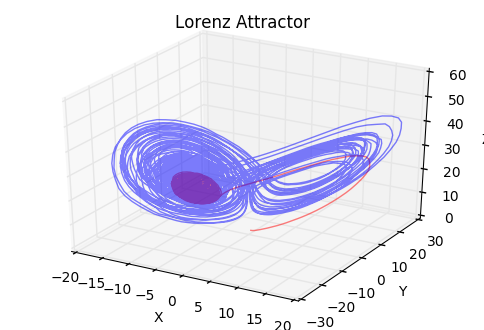

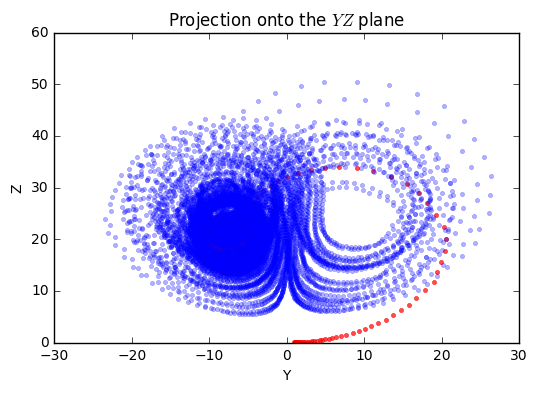

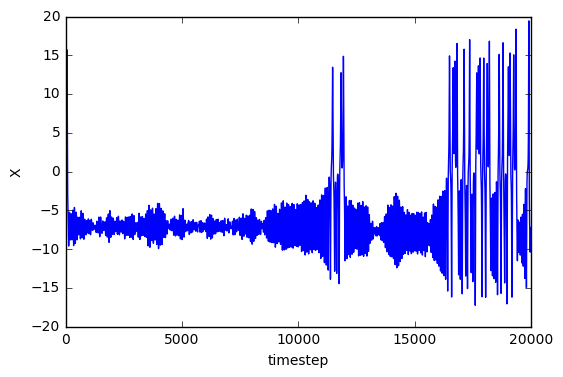

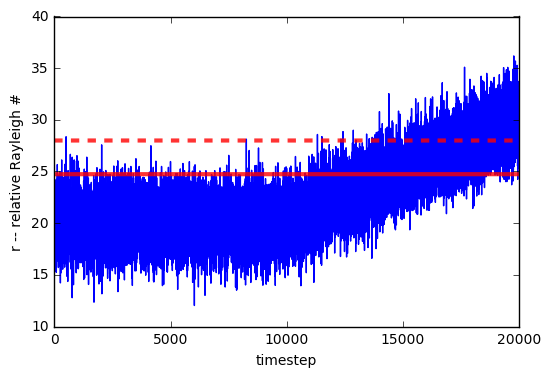

In [6]:
#Again start the Lorenz model with the same state that Lorenz uses in the 1963 paper
xyz = np.array([0,1,0],dtype=np.float)

#Set the number of timesteps
nstep = 20000
#Set the start and end values of r
rstart = 20
rend = 30
#Set the scale of the noise
noiseScale = 2
#Set the 1st half with quasi-constant (but noisy) sub-critical r
r = rstart*np.ones([int(nstep/2)]) + np.random.normal(scale=noiseScale,size=int(nstep/2))
#Concatenate that half with the second half that linearly increases to a super-critical value
#(again with the same level of noise)
r = np.concatenate((r, \
                    np.linspace(rstart,rend,int(nstep/2)) + np.random.normal(scale=noiseScale,size=int(nstep/2)), \
                ))
#Run the model
xyzOut = integrateL63(xyz,nstep=len(r),r=r)

#********************
# Plot model's state
#********************
#initialize the figure
fig = PP.figure()
ax = fig.gca(projection='3d')

#extract the state variables from the output
xs = xyzOut[0,:]
ys = xyzOut[1,:]
zs = xyzOut[2,:]

#Plot the first half of the timeseries as red
s = slice(None,int(len(r)/2))
ax.plot(xs[s], ys[s], zs[s],color='r',alpha=0.5)
#Plot the 2nd half as blue
s = slice(int(len(r)/2),None)
ax.plot(xs[s], ys[s], zs[s],color='b',alpha=0.5)

#set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")

PP.show()

#Plot the projection onto the YZ plane
s = slice(None,int(len(r)/2))
PP.plot(ys[s],zs[s],'r.',alpha=0.7)
s = slice(int(len(r)/2),None)
PP.plot(ys[s],zs[s],'b.',alpha=0.3)
PP.xlabel('Y')
PP.ylabel('Z')
PP.title('Projection onto the $YZ$ plane')
PP.show()

#***************************
# Plot timeseris of X and r
#***************************
PP.plot(xs)
PP.xlabel('timestep')
PP.ylabel('X')
PP.show()
PP.plot(r)
rcrit = 24.74 #Relative critical Rayleigh # above which convection starts (from Lorenz 1963)
PP.plot(np.arange(len(r)),rcrit*np.ones(len(r)),color='r',alpha=0.8,linewidth=3)
PP.plot(np.arange(len(r)),28*np.ones(len(r)),color='r',linestyle='--',alpha=0.8,linewidth=3)
PP.ylabel('r -- relative Rayleigh #')
PP.xlabel('timestep')
PP.show()



So when we force the Lorenz model with a critical Rayleigh number that has a large amount of noise, but is well below the convection threshold of $r=24.74$, the system appears to be in a quasi-periodic state that orbits tightly around the left attractor (e.g., see the red curve in the Lorenz Attractor figure above).  However, once we start to change the relative Rayleigh number, the system starts to transition to the chaotic and non-periodic state where the system orbits both attractors (the blue curve in the Lorenz Attractor figure).  This manifests a change in the temporal behavior of the state variables that is characteristic of the non-periodic orbit.  The timeseries of $X$ given above goes from having a relatively small variance around $X \approx -7$ to having a huge and chaotic timeseries that ranges from $X \approx \pm 15$; this transition beings around timestep $14,000$, which is just about the time that $r$ starts to spend most of its time above $r=24.74$.

# Sound of L63 model
Out of curiosity, I wondered what the Lorenz model sounds like in the quasi-periodic regime?  The timeseries in the quasi periodic regime has structure that might sound interesting.

To listen to this, I re-ran the model with constant r, and with a higher timestep.

In [7]:
import wave

#Again start the Lorenz model with the same state that Lorenz uses in the 1963 paper
xyz = np.array([0,1,0],dtype=np.float)

#Set the number of timesteps
nstep = 1000000
#Set the value of r
rstart = 20
#Set the scale of the noise
noiseScale = 2
#Set the r timeseris (with noise)
r = rstart*np.ones([nstep]) + np.random.normal(scale=noiseScale,size=nstep)
#set a smaller timestep than default
deltaT = 0.001
#Run the model
xyzOut = integrateL63(xyz,nstep=len(r),r=r,deltaT=deltaT)

#extract the state variables from the output
xs = xyzOut[0,:]
ys = xyzOut[1,:]
zs = xyzOut[2,:]

#Open a wave file
noise_output = wave.open('l63.wav', 'w')
noise_output.setparams((3, 2, 48000, 0, 'NONE', 'not compressed'))

#Standardize the X,Y,Z values and convert them to
wavMax = 32767
xsScaled = np.clip(wavMax*(xs - np.average(xs))/(4*np.std(xs)),-wavMax,wavMax)
ysScaled = np.clip(wavMax*(ys - np.average(ys))/(4*np.std(ys)),-wavMax,wavMax)
zsScaled = np.clip(wavMax*(zs - np.average(zs))/(4*np.std(zs)),-wavMax,wavMax)
outData = [ [wave.struct.pack('h',int(x)),wave.struct.pack('h',int(y)),wave.struct.pack('h',int(z))] for x,y,z in zip(xsScaled,ysScaled,zsScaled)]

noise_output.writeframes(b''.join([val for item in outData for val in item]))
noise_output.close()

In [8]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
from IPython.core.display import HTML
from IPython.core.display import display
#Taken from http://nbviewer.ipython.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb 
#on 4/5/15 at 10:18 PDT
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

wavPlayer('l63.wav')

Hmm...not particularly interesting.  It sounds a lot like red noise.